# Uncertainty in DL: MC-Dropout

이 세션에서는 베이지안 근사치로서의 드롭아웃에 설명된 대로 몬테카를로 드롭아웃을 이해하고 구현하는 것을 목표로 합니다: 딥러닝에서 모델 불확실성 표현하기.

![](https://github.com/charlesollion/dlexperiments/raw/master/6-Bayesian-DL/BDLworkflow.png)

## Installation

In [ ]:
pip install pytorch

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## The dataset

'Wine Qiuality'을 사용합니다. 4,898개의 예가 포함된 레드 와인 하위 집합을 사용합니다. 이 데이터 집합에는 와인의 11가지 물리화학적 특징이 수치로 표시되어 있으며, 0에서 10 사이의 점수인 와인 품질을 예측하는 것이 과제이다.

전문가들은 정수로 점수를 주었지만, 단순하고 신뢰 구간을 쉽게 해석하기 위해 먼저 0에서 10 사이의 연속 값으로 간주하고 이를 회귀 작업으로 처리한다. 데이터를 보다 연속적으로 만들기 위해 y에 작은 관측 노이즈를 추가한다.

In [3]:
# load data
df = pd.read_csv('../dataset/wine_quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,rate
0,7.6,0.32,0.34,18.35,0.054,44.0,197.0,1.00080,3.22,0.55,9.0,5.0
1,6.3,0.27,0.49,1.20,0.063,35.0,92.0,0.99110,3.38,0.42,12.2,6.0
2,5.3,0.43,0.11,1.10,0.029,6.0,51.0,0.99076,3.51,0.48,11.2,4.0
3,6.6,0.41,0.27,10.70,0.110,20.0,103.0,0.99672,3.08,0.41,9.0,6.0
4,5.9,0.34,0.30,3.80,0.035,57.0,135.0,0.99016,3.09,0.34,12.0,6.0


In [4]:
df.shape

(4898, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  rate                  4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,rate
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Feature Engineering

In [7]:
X = df.drop('rate', axis=1)
y = df['rate']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4163, 11), (735, 11), (4163,), (735,))

In [9]:
# y_train에 약간의 노이즈 추가
y_train = y_train + np.random.normal(0,0.2, size=y_train.shape)

In [10]:
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# transform to torch tensor
tensor_X_train = torch.from_numpy(X_train).float().to(device) 
tensor_y_train = torch.from_numpy(y_train.values).float().to(device) 
tensor_X_test = torch.from_numpy(X_test).float().to(device) 
tensor_y_test = torch.from_numpy(y_test.values).float().to(device) 

In [12]:
batch_size = 256

In [13]:
# build dataset and dataloader torch objects
dataset_train = TensorDataset(
    tensor_X_train, tensor_y_train
)
dataset_test = TensorDataset(
    tensor_X_test, tensor_y_test
)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    shuffle=True
)
dataloader_test = DataLoader(
    dataset_test, 
    batch_size=batch_size
)

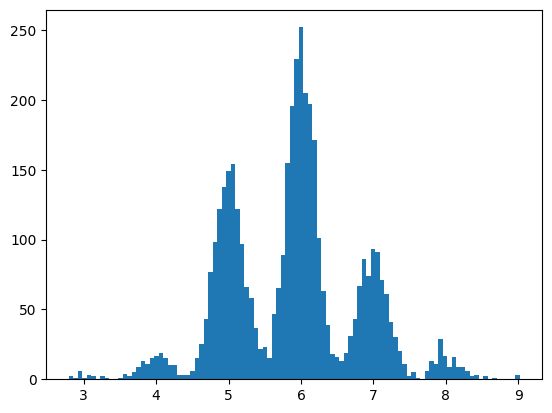

In [14]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=100);

## Baseline: Standard Neural Network

In [15]:
import torch.nn as nn

class BaselineMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BaselineMLP, self).__init__()
        self.hidden_layer1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.act = torch.relu
        
    def forward(self, inputs):
        # First layer
        h = self.hidden_layer1(inputs)
        h = self.act(h)
        # Second layer
        h = self.hidden_layer2(h)
        h = self.act(h)
        output = self.out_layer(h)
        
        return output

In [16]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model, num_epochs):
    optimizer = optim.RMSprop(model.parameters(), lr=0.003, weight_decay=1e-5)
    loss = torch.nn.MSELoss()
    losses = []
    model.train()
    for e in tqdm(range(num_epochs)):
        for x, y in dataloader_train:
            optimizer.zero_grad()
            loss_value = loss(model(x), y)
            loss_value.backward()
            losses.append(loss_value.detach().cpu().item())
            optimizer.step()
    return losses


def eval_model(model):
    model.eval()
    errors = []
    for x,y in dataloader_test:
        y_hat = model(x)
        errors.append(((torch.squeeze(y_hat) - torch.squeeze(y))**2).detach().cpu().numpy())
  
    rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
    return round(rmse, 3)

In [17]:
baseline_model = BaselineMLP(11, 32).to(device)
baseline_model

BaselineMLP(
  (hidden_layer1): Linear(in_features=11, out_features=32, bias=True)
  (hidden_layer2): Linear(in_features=32, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
[p.numel() for p in baseline_model.parameters()]
# hidden layer W, hidden layer b, output layer W, output layer b

[352, 32, 1024, 32, 32, 1]

### Baseline evaluations
학습되지 않은 모델 RMSE와 매우 멍청한 상수 모델(단지 y_train의 평균을 예측하는 모델)을 살펴보면:

In [20]:
rmse = eval_model(baseline_model)
print(f"untrained RMSE: {rmse:.3f}")

untrained RMSE: 5.922


In [22]:
class Constant():
    def eval(self):
        pass
    
    def __call__(self, x):
        return torch.ones((x.shape[0], 1)).to(device) * np.mean(y_train)

rmse = eval_model(Constant())
print(f"constant model RMSE: {round(rmse, 3):.3f}")

constant model RMSE: 0.916


### Training model

  0%|          | 0/50 [00:00<?, ?it/s]/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([67])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


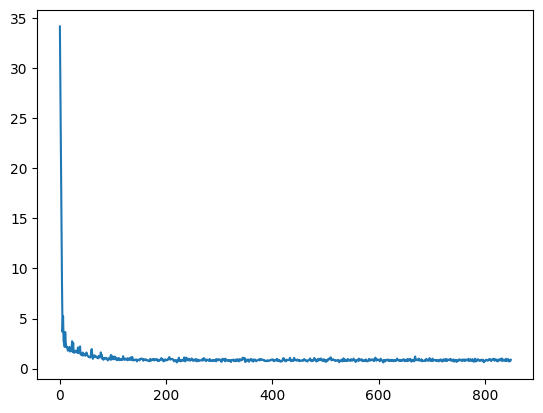

In [23]:
losses = train_model(baseline_model, 50)

plt.plot(losses);

In [24]:
rmse = eval_model(baseline_model)
print(f"trained RMSE: {rmse:.3f}")

trained RMSE: 0.950


In [ ]:
samples = 10
# first ten examples
examples_torch, _ = next(iter(dataloader_test))
predicted = baseline_model(examples_torch[:samples])
predicted = predicted.detach().cpu().numpy()
for idx in range(samples):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {y_test[idx].item()}")

In [27]:
samples = 10

# first ten examples
examples_torch, y_test = next(iter(dataloader_test))  # 라벨 포함 데이터 가져오기
predicted = baseline_model(examples_torch[:samples])  # 모델 예측
predicted = predicted.detach().cpu().numpy()  # NumPy로 변환

for idx in range(samples):
    # 실제값과 예측값 출력
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {y_test[idx].item()}")

Predicted: 5.7 - Actual: 6.0
Predicted: 5.9 - Actual: 6.0
Predicted: 5.8 - Actual: 4.0
Predicted: 5.7 - Actual: 5.0
Predicted: 5.6 - Actual: 7.0
Predicted: 5.6 - Actual: 6.0
Predicted: 5.7 - Actual: 7.0
Predicted: 5.7 - Actual: 5.0
Predicted: 5.7 - Actual: 7.0
Predicted: 5.7 - Actual: 6.0


## Simple Dropout Mode
다음에서는 확률적 가중치로 구성된 선형 레이어를 구현하는 것으로 시작합니다. 출력 레이어는 이전과 동일하게 유지됩니다.

In [28]:
import torch.nn as nn

class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_proba):
        super(DropoutMLP, self).__init__()
        self.hidden_layer1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_proba)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_proba)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.act = torch.relu
        
    def forward(self, inputs):
        # First layer
        h = self.hidden_layer1(inputs)
        h = self.act(h)
        h = self.dropout1(h)
        # Second layer
        h = self.hidden_layer2(h)
        h = self.act(h)
        h = self.dropout2(h)
        # Output layer
        output = self.out_layer(h)
        return output

In [29]:
dropout_model = DropoutMLP(11, 32, 0.1).to(device)
[p.numel() for p in dropout_model.parameters()]
#mu, rho, W_output, b_output, batch_norm mu, batch_norm sigma

[352, 32, 1024, 32, 32, 1]

100%|██████████| 200/200 [00:12<00:00, 15.89it/s]


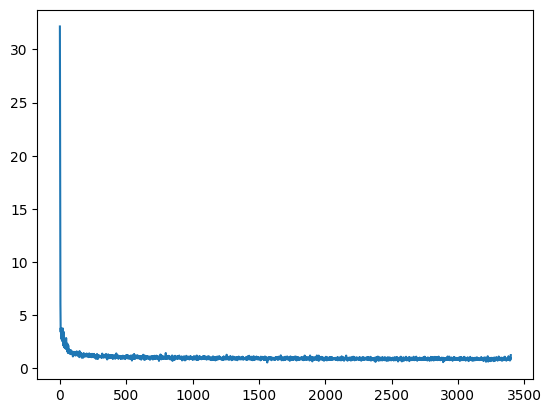

In [30]:
losses = train_model(dropout_model, 200)
plt.plot(losses);

### Evaluating the model
이제 단일 추정치 대신 예측 분포가 있으므로 여러 개의 드롭아웃 마스크를 샘플링하고 테스트 세트의 각 예제에 대해 여러 예측을 계산할 수 있습니다. 이를 통해 분포 평균, 분산을 확인하거나 히스토그램을 표시할 수 있다.

하지만 먼저 MC 드롭아웃이 아닌 표준 드롭아웃에서 전통적으로 수행되는 결정론적 방식으로 모델을 평가해 보면:

In [31]:
# 확률적이지 않은 드롭아웃은 테스트 시점에 다른 동작을 합니다(가중치에 1-p를 곱함).
rmse = eval_model(baseline_model)
print(f"trained deterministic network RMSE: {rmse:.3f}")

trained deterministic network RMSE: 0.950


In [39]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def compute_predictions(model, n_samples=20):
    """ Compute `n_samples` predictions for each example in the test set"""
    model.eval()
    enable_dropout(model)  # 테스트 시간에 드롭아웃 활성화
    n_test = len(dataset_test)
    dropout_predictions = np.zeros((n_samples, n_test))
    
    for i in range(n_samples):
        with torch.no_grad():
            batch_y = np.squeeze(model(tensor_X_test.to(device)).cpu().numpy())
            dropout_predictions[i] = batch_y

    mean = np.mean(dropout_predictions, axis=0)  # 예측값 평균
    variance = np.var(dropout_predictions, axis=0)  # 예측값 분산
    return dropout_predictions, mean, variance

In [40]:
preds, mean, var = compute_predictions(dropout_model)

In [42]:
def display_predictions(predictions, targets, idxs):
    """ Display predictions for examples in the test set indexed by the list `idxs`"""
    prediction_mean = np.mean(predictions, axis=0).tolist()
    prediction_min = np.min(predictions, axis=0).tolist()
    prediction_max = np.max(predictions, axis=0).tolist()
    prediction_range = (np.max(predictions, axis=0) - np.min(predictions, axis=0)).tolist()

    for idx in idxs:
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx].item()}"
        )
    plt.boxplot(predictions[:, idxs].T)
    plt.plot(range(1, len(idxs) + 1), targets[idxs].cpu().numpy(), 'r.', alpha=0.8)
    plt.xlabel("Sample Index")
    plt.ylabel("Prediction")
    plt.title("Prediction Boxplot with Actual Values")
    plt.show()

Predictions mean: 5.92, min: 5.54, max: 6.28, range: 0.74 - Actual: 8.0
Predictions mean: 5.95, min: 5.35, max: 6.28, range: 0.93 - Actual: 5.0
Predictions mean: 5.83, min: 5.01, max: 6.28, range: 1.28 - Actual: 7.0
Predictions mean: 5.9, min: 5.39, max: 6.29, range: 0.9 - Actual: 6.0
Predictions mean: 5.95, min: 5.38, max: 6.28, range: 0.91 - Actual: 7.0
Predictions mean: 5.87, min: 5.39, max: 6.28, range: 0.89 - Actual: 5.0
Predictions mean: 5.88, min: 4.58, max: 6.29, range: 1.72 - Actual: 5.0
Predictions mean: 5.9, min: 5.56, max: 6.28, range: 0.73 - Actual: 7.0
Predictions mean: 5.78, min: 5.02, max: 6.11, range: 1.09 - Actual: 5.0
Predictions mean: 5.85, min: 5.34, max: 6.28, range: 0.95 - Actual: 7.0


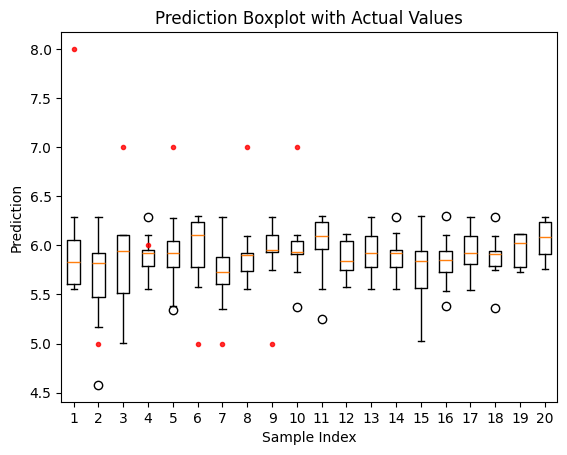

In [44]:
# 유효한 예측 범위 내에서 무작위 인덱스 생성
idxs = np.random.choice(range(min(preds.shape[1], len(y_test))), size=10, replace=False)

# 선택한 인덱스에 대한 예측 표시
display_predictions(preds, y_test, idxs)

단일 추정치와 비교할 때, 예측의 경험적 평균은 RMSE가 더 낮다:

In [50]:
errors = []
for y_hat, y in zip(mean, y_test.cpu().numpy()):
    errors.append((y_hat - y)**2)

rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
print(f"mean prediction RMSE: {round(rmse, 3):.3f}")

mean prediction RMSE: 0.923


또한 모델이 일정한 값이 아닌 테스트 예제에 따라 달라지는 변수를 생성하는 것을 확인할 수 있다:

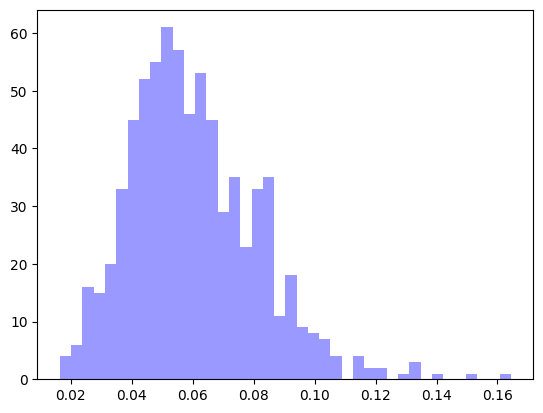

In [51]:
plt.hist(var, bins=40, alpha=0.4, color="b");

## Comparing different values of $p$

하이퍼파라미터로 선택한 $p$의 다양한 값의 결과가 $p=0.1, p=0.2$와 같은 다양한 값으로 비슷한 결과(즉, 분산)로 수렴해야 한다.

예를 들면 $p=0.5$를 선택하여 $p$의 여러 값을 테스트할 수 있으며 수렴을 보장하기 위해 에포크 수를 늘리는 것도 좋은 방법일 수 있다($p$가 높을수록 느려짐).

분산은 Emprical Varation을 계산:
$$V_{q(y^\-star|x^\-star)} = V^{empirical} + τ^{-1}$$

여기서 $τ = \frac{pl^2}{2N\lambda}$, $p$는 탈락 확률, $l$은 가중치 초기화에 따른 초모수, $N$은 데이터 포인트 수, $\lambda$는 가중치 감쇠 파라미터이다. 실제로는 다른 파라미터를 조정할 수 있으므로 경험적 분산만 사용한다.(예를 들어 가중치 감쇠는 임의로 작게 설정하여 $τ^{-1}$를 무시할 수 있다.).

In [54]:
variances =[]
for p in [0.0, 0.01, 0.1, 0.2, 0.4]:
    print(f"training model with p={p}")
    dropout_model = DropoutMLP(11, 32, p).to(device)
    losses = train_model(dropout_model, 200)
    preds, mean, var = compute_predictions(dropout_model)
    variances.append(var)
    
    errors = []
    for y_hat, y in zip(mean, y_test.cpu().numpy()):
        errors.append((y_hat - y)**2)

    rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
    print(f"p={p} mean prediction RMSE: {round(rmse, 3):.3f}")
    print(f"p={p} average variance: {np.mean(var):.3f}")

training model with p=0.0


100%|██████████| 200/200 [00:12<00:00, 16.16it/s]


p=0.0 mean prediction RMSE: 0.903
p=0.0 average variance: 0.000
training model with p=0.01


100%|██████████| 200/200 [00:13<00:00, 14.75it/s]


p=0.01 mean prediction RMSE: 0.915
p=0.01 average variance: 0.017
training model with p=0.1


100%|██████████| 200/200 [00:13<00:00, 14.70it/s]


p=0.1 mean prediction RMSE: 0.945
p=0.1 average variance: 0.050
training model with p=0.2


100%|██████████| 200/200 [00:13<00:00, 14.93it/s]


p=0.2 mean prediction RMSE: 0.917
p=0.2 average variance: 0.053
training model with p=0.4


100%|██████████| 200/200 [00:12<00:00, 15.48it/s]

p=0.4 mean prediction RMSE: 0.916
p=0.4 average variance: 0.010


In [55]:
np.vstack(variances[:]).T.shape

(735, 5)

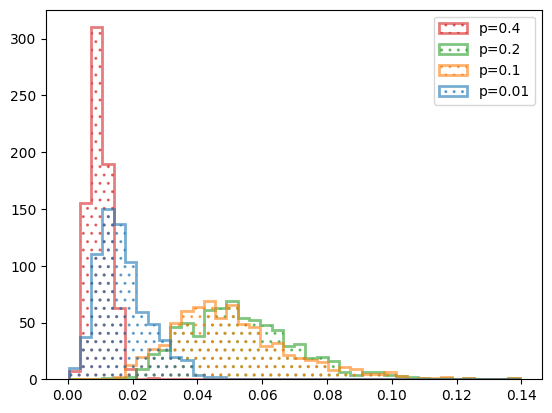

In [56]:
plt.hist(np.vstack(variances[1:]).T, histtype='step', bins=40, label=[f"p={p}" for p in [0.01, 0.1, 0.2, 0.4]], 
         fill=False, alpha=0.6, linewidth=2, hatch='..');
plt.legend();

In [58]:
# long run
p = 0.2
print(f"training model with p={p}")

dropout_model = DropoutMLP(11, 32, p).to(device)
losses = train_model(dropout_model, 1000)
preds, mean, var = compute_predictions(dropout_model)

errors = []
for y_hat, y in zip(mean, y_test.cpu().numpy()):
    errors.append((y_hat - y)**2)

rmse = np.sqrt(np.mean(np.concatenate(errors, axis=None)))
print(f"p={p} mean prediction RMSE: {round(rmse, 3):.3f}")
print(f"p={p} average variance: {np.mean(var):.3f}")

training model with p=0.2


100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]

p=0.2 mean prediction RMSE: 0.916
p=0.2 average variance: 0.000


Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 6.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 5.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 6.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 7.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 6.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 7.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 7.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 6.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 7.0
Predictions mean: 5.87, min: 5.87, max: 5.87, range: 0.0 - Actual: 6.0


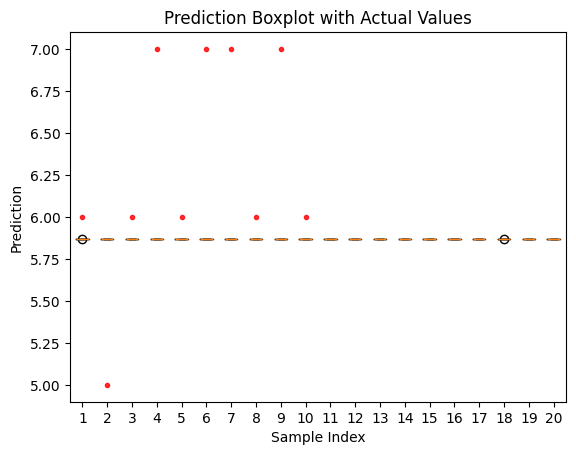

In [76]:
# 유효한 예측 범위 내에서 무작위 인덱스 생성
idxs = np.random.choice(range(min(preds.shape[1], len(y_test))), size=10, replace=False)

# 선택한 인덱스에 대한 예측 표시
display_predictions(preds, y_test, idxs)